In [ ]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dataclasses import dataclass
import random
from enviroments import env_red_toy, env_red_toy1
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list
from algorithms.DQL import DQL_algorithm
from algorithms.QL import QL_algorithm
import time
from algorithms.models import QfunNN

NUMERO_DE_NUCLEOS = 16

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [6]:
name_exp = "Exp5"
Red_name = "red1"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN" #Puede ser LR/NN

In [7]:
T = 400

env = env_red_toy1(Demand_Model,T)

#Hiperarametros del algoritmo
gamma = 1
alpha = 1e-3
eps = 1.0
n = 4
eps_decay = 0.999997**(1/n*(env.T/50))
batch_size = 200

#Tamaño de la ejecución
max_episodes = 70000*n
max_steps = T

#Tamaño del bufer
buffer_size = 50_000

#Hiperparametros del modelo
num_inputs = env.I + 1
exp_layers =[
    [128,128,128]
]
num_outputs = len(env.action_space)


In [8]:
R_exp = []
time_exp = []
qnet_exp = []

for i, num_hiddens in enumerate(exp_layers):
    
    print(f"Experimento {i}:")

    qnet = QfunNN(num_inputs, num_hiddens, num_outputs).double()
    opt = torch.optim.Adam(qnet.parameters(), lr=alpha)
    
    start_time = time.time()
    qnet, Rs, eps = DQL_algorithm(max_episodes,max_steps,buffer_size, env, qnet,eps_decay,opt,gamma,batch_size,num_outputs)
    end_time = time.time()
    execution_time = end_time - start_time

    R_exp.append(Rs)
    time_exp.append(execution_time)
    qnet_exp.append(qnet)



Experimento 0:


Experimento 1: 16390.0 
Experimento 2: 19930.0 


In [9]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qnet_exp


with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [10]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qnet_exp = exp["qfun_exp"] 


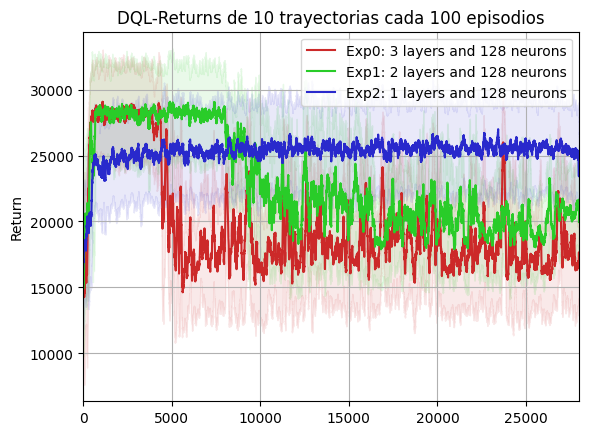

In [11]:
from algorithms.utils import generate_random_colors

num_plots = len(R_exp)  # Número de gráficas
colors = ['#' + ''.join(np.random.choice(list('0123456789ABCDEF'), size=6)) for _ in range(num_plots)]
colors = generate_random_colors(num_plots)

for i, R in enumerate(R_exp):

    Rs = np.array(R).ravel()

    mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label= f"Exp{i}: {len(exp_layers[i])} layers and {exp_layers[i][0]} neurons")
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.1)

    plt.xlim(0, len(Rs))
    plt.grid()
    plt.ylabel("Return")
    plt.legend()
    plt.title("DQL-Returns de 10 trayectorias cada 100 episodios")

plt.savefig("results/"+ name_exp +"/Returns_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

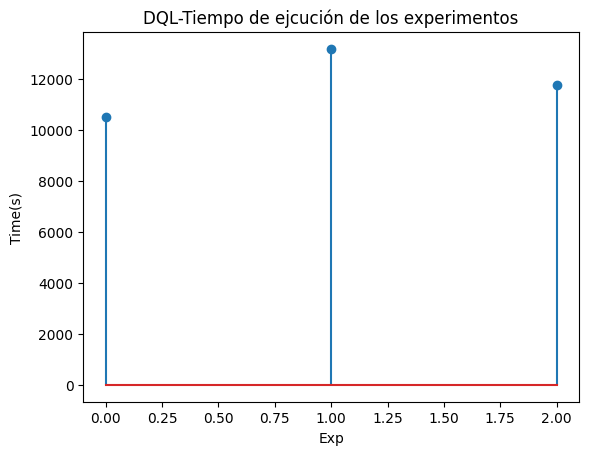

In [12]:
plt.title("DQL-Tiempo de ejcución de los experimentos")
plt.stem(time_exp)
plt.xlabel("Exp")
plt.ylabel("Time(s)")

plt.savefig("results/"+ name_exp +"/Time_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [13]:
from algorithms.utils import saveGIFT

saveGIFT(env, qnet_exp, "NN", [0,1], "results/"+ name_exp +"/Qfun_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".gif")

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
#from algorithms.utils import compare_Qfun_exp

#name = "results/"+ name_exp +"/SelfQfunDiff_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png"
#diff_matrix = compare_Qfun_exp(env,qnet_exp,Qfun_model,name)

KeyboardInterrupt: 